### Important variables 

Deptext = Depression text-response <br> 
Wortext = Worry text-response

dep_all_phraces = Depression all phraces responses <br> 
wor_all_phraces = Worry all phraces responses

dep_all_word = Depression all descriptive word responses <br>
wor_all_words = Worry all descriptive word responses

dep_all_selected1 = All selected depression word responses <br>
wor_all_selected1 = All selected worry word responses

<hr style="border:1px solid gray"> </hr>

CESDtot = Center for Epidemiological Studies Depression (CESD) <br>
PHQtot = PHQ-9 = Patient Helath Questionnaire = a depression scale

GADtot = GAD-7 = Generalized anxiety disorder scale <br>
PSWQtot = Penn State Worry Questionniare 

<hr style="border:1px solid gray"> </hr>

miniGAD_diagnose = Self-reported MINI (structured interview) GAD diangose <br>
minidep_diagnose = Self-reported MINI (structured interview) MDD (depression) diangose

#### Importing and cleaning dataset

In [416]:
import keras
import math
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [352]:
#Get relative directory to find path
path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
responses = pd.read_csv(path, sep=';', header=0)
responses.drop(responses.columns[[0]], axis=1, inplace=True)
responses.head()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2


### Dataset distribution for: 
#### dep vs. non-dep resonses & anx vs. non-anx responses

In [353]:
print("Count responses with/without diagnosed depression:\n",responses.minidep_diagnose.value_counts())
print("\nCount responses with/without diagnosed anxiety:\n",responses.miniGAD_diagnose.value_counts())

Count responses with/without diagnosed depression:
 0    652
1    324
Name: minidep_diagnose, dtype: int64

Count responses with/without diagnosed anxiety:
 1    499
0    477
Name: miniGAD_diagnose, dtype: int64


#### Importing and cleaning semantic space 

In [354]:
"""
Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
where the rows contained the 120,000 most common words in the n-gram database and the columns 
consisted of the 10,000 most common words in the n-gram database.

The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
"""
path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
space = pd.read_csv(path, encoding= 'unicode_escape')
space.set_index('words', inplace=True)
space.drop(space.columns[[0]], axis=1, inplace=True)
space.dropna(inplace=True)
space = space[~space.index.duplicated(keep='first')]

In [355]:
space.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512
words,,,,,,,,,,,,,,,,,,,,,
was,-0.234071,-0.278211,-0.100658,-0.269570,-0.115498,-0.000038,-0.036835,0.024037,-0.003974,0.006582,...,-0.011414,0.018075,-0.020312,0.001287,0.024483,0.012867,0.021265,0.016368,0.024858,-0.020382
not,-0.283230,-0.338776,-0.141085,-0.243715,-0.236692,-0.033354,-0.099906,0.053253,-0.025582,-0.040372,...,-0.028472,0.048824,-0.025452,0.007828,0.027658,-0.022135,0.023037,0.005371,-0.001482,-0.024063
by,-0.251058,-0.327183,-0.203889,-0.283337,-0.124522,-0.006537,0.015371,0.131667,-0.130597,0.055605,...,-0.001550,0.027915,-0.012646,-0.005019,0.075544,0.014663,0.013489,-0.022636,0.010127,-0.027951
that,-0.281888,-0.346746,-0.171006,-0.266698,-0.208917,-0.019832,-0.035404,0.044301,-0.076601,0.021328,...,0.019319,0.042742,0.001747,0.019198,0.022598,0.034352,0.033282,-0.006843,0.027052,-0.013623
of,-0.256530,-0.335434,-0.229791,-0.256070,-0.120020,0.017080,0.078004,0.112134,-0.073805,0.098183,...,0.012012,0.005470,-0.022383,-0.042172,-0.003430,-0.013435,0.003697,-0.022769,0.024873,0.010061


#### Methods for cleaning and aggregating semantic responses

In [446]:
"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""
words_in_space = set(space.index.values)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        try:
            tokens = word_tokenize(text)
            words = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha()]
            #words = [w for w in words if not w in stop_words] #Uncomment if stop words should be excluded
            cleaned_words = [w for w in words if w in words_in_space] # TODO: Hantera ord som inte finns i spacet. Nu ignoreras dem.
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []

In [447]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""

space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [448]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors

#### Extracting semantic responses and representing the answer to each question in the semantic space. 

In [449]:
dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
df_dep_responses = responses[dep_columns]

df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)

In [450]:
wor_columns = ['Wortext', 'wor_all_phraces', 'wor_all_words', 'wor_all_selected1']
df_wor_responses = responses[wor_columns]

df_wor_aggregated = df_wor_responses.apply(aggregate_cell, axis=1)

In [451]:
df_dep_aggregated.iloc[:10]

,Deptext,dep_all_phraces,dep_all_words,dep_all_selected1
0,"[0.13613790309834578, 0.19275906710260687, 0.0...","[-0.7590918166513144, -0.7996448245182226, 0.6...","[-0.1273549613905489, -0.08134255488745974, 0....","[-0.10631367041145831, -0.07611765664843519, 0..."
1,"[0.1825447368707929, 0.25064255992349477, 0.00...","[0.3541407136004046, 0.46792086506723923, -0.0...","[1.4817085495650901, 1.6852794755670726, -1.02...","[-0.4464577452018576, -0.3896723426287449, 0.2..."
2,"[0.1770099694466632, 0.25148440795916216, 0.05...","[0.09516196520436199, 0.12478697093359738, 0.0...","[0.12709153308204263, 0.14295118020024064, -0....","[-0.07663349903279251, -0.0006333442681840741,..."
3,"[0.1631703484550944, 0.2245410993649726, 0.025...","[0.27915098171748887, 0.3671093426009795, -0.0...","[0.02563310976259593, 0.008765453890638979, -0...","[-0.07360932328901604, -0.039037012259667915, ..."
4,"[0.20230291635768588, 0.2853068791632969, 0.04...","[0.39916260826011735, 0.4636167724424403, -0.1...","[0.11984013084382182, 0.1388116450206766, -0.0...","[53.49798528434856, 36.203814272230716, -104.1..."
5,"[0.14907787123789526, 0.21124894112920292, 0.0...","[0.41638292399978516, 0.5368902458559509, -0.0...","[-0.026319931002123535, -0.008734687972281292,...","[-0.09433512754889452, -0.04938581939782909, 0..."
6,"[0.2009297538064387, 0.28301130394135704, 0.04...","[0.37825238167913144, 0.5193728920865776, 0.10...","[-0.21575673903918458, -0.17254878886225875, 0...","[-0.07639443687669704, -0.06505044300142823, 0..."
7,"[0.1848307124303776, 0.2574292282297854, 0.031...","[0.12799964215155124, 0.17547507189505657, 0.0...","[-0.1956163858582564, -0.14930168873878932, 0....","[0.2828556887611595, 0.25211172678271127, -0.3..."
8,"[0.20937401512411524, 0.286544013739526, 0.002...","[-0.4567649142131917, -0.1752281301733484, 0.4...","[-0.13907052976579662, -0.08380077038092038, 0...","[-2.01485573050681, -1.7268435631282695, 3.160..."
9,"[0.1577551439471301, 0.21900580357892296, 0.01...","[0.22053886191297054, 0.3049822722671312, 0.03...","[-0.3710269064624871, -0.3872365612823404, 0.1...","[-0.2317635994266965, -0.2015510492531913, 0.2..."


In [395]:
df_wor_aggregated.iloc[:10]

,Wortext,wor_all_phraces,wor_all_words,wor_all_selected1
0,"[0.1440514596352557, 0.20141436353848827, 0.02...","[0.16848163704578215, 0.21104085954673157, 0.0...","[0.08512889256007852, 0.06930940294720918, -0....","[-0.03628907508059879, -0.028415450913131548, ..."
1,"[0.16221587408595114, 0.22684020078508843, 0.0...","[1.1103460078580998, 1.4593275856203258, -0.05...","[-0.5054823889786489, -0.1719085052464023, 0.2...","[-0.04345398189988291, -0.020184341988825145, ..."
2,"[0.15812818828114703, 0.2239590625026475, 0.04...","[0.10662762521250929, 0.12498854698322394, -0....","[0.07113400315024147, 0.07405232367513156, -0....","[-0.24450141879414833, -0.1207688415568227, 0...."
3,"[0.14795344298846416, 0.20968190054576208, 0.0...","[-0.2093961036417866, -0.02262574654514593, 0....","[-0.06529720047146943, 0.046267332309030004, 0...","[-0.14872175998100662, -0.09152232772736162, 0..."
4,"[0.1752550866091929, 0.24824590725705303, 0.04...","[0.268473440352966, 0.3316357580608249, 0.0003...","[-0.08879341781163713, -0.0742497412666487, 0....","[-0.06327165709289427, -0.041942097040231004, ..."
5,"[0.20078569628208717, 0.2777705180750936, 0.01...","[0.4689012534629255, 0.5876218339044467, -0.04...","[-0.30424776300405076, -0.04949671606636565, 0...","[-0.041991902728896593, -0.02405995612369255, ..."
6,"[0.20703558982337247, 0.2920883927614394, 0.03...","[0.14576502455322274, 0.20067097239874168, 0.0...","[0.11098324236286271, 0.03640903903022071, -0....","[0.3334432322058589, 0.26953732272642683, -0.2..."
7,"[0.1664209545686214, 0.23632612330216007, 0.04...","[0.15949162503114026, 0.21007226618203734, -0....","[-0.2617804024662393, 0.007203681762336878, 0....","[0.06378269752602983, 0.008016117756634659, -0..."
8,"[0.2136898310695309, 0.293574840486361, 0.0004...","[0.116359056223289, 0.018585133221237247, -0.3...","[0.06984923510555656, 0.006518063912136102, -0...","[0.08754686825446147, 0.06462605258728954, -0...."
9,"[0.18187521694341757, 0.2552185279809584, 0.03...","[0.17554926424116052, 0.2157095366202666, -0.0...","[-0.10305678157119341, -0.04645025593640237, 0...","[-0.31795743940750415, -0.17534088139707674, 0..."


In [453]:
def concat_vectors(row):
    return np.concatenate(row.values).ravel()

df_dep_concat = pd.DataFrame(preprocessing.normalize(list(df_dep_aggregated.apply(concat_vectors, axis=1)), norm='l2'))
df_wor_concat = pd.DataFrame(preprocessing.normalize(list(df_wor_aggregated.apply(concat_vectors, axis=1)), norm='l2'))

### Concatinating the semantic representations for each question into one multidimensional response vector
Each participant's semantic responses are now represented by two 2048 dimension vectors. 
One for depression-words and one for anxiety-words

In [568]:
df_wor_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.111800,0.156252,0.016540,0.090816,0.062396,-0.002632,0.016856,-0.023679,0.015809,-0.001524,...,0.006904,0.001995,-0.026127,0.014520,0.001973,0.008508,0.021253,0.018011,0.035153,-0.007484
1,0.014327,0.020044,0.001878,0.012357,0.008009,-0.000327,0.001485,-0.001470,0.002374,-0.000731,...,0.003547,0.002681,0.005422,0.002154,0.001099,0.002285,-0.001693,-0.000821,-0.000881,0.002475
2,0.053904,0.076461,0.015571,0.039024,0.028861,-0.002109,0.008858,-0.014443,0.008779,-0.009567,...,0.062247,0.074144,-0.001594,0.011099,-0.019784,0.010750,0.019738,0.029043,-0.032125,0.024646
3,0.032747,0.046601,0.010341,0.026081,0.017217,-0.001874,0.003749,-0.010849,0.005793,-0.003825,...,0.010818,0.010128,0.015741,-0.011873,-0.013022,0.026603,-0.003381,0.004701,0.013584,0.008080
4,0.120449,0.170719,0.028594,0.099667,0.066456,-0.008589,0.015159,-0.022729,0.020385,-0.009194,...,-0.019117,0.039220,0.008256,-0.018508,-0.023898,0.002626,-0.005674,0.005413,0.002019,0.028021


## Performing principal component analysis to reduce the number of dimensions for the concatinated semantic vectors

In [440]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_dim(k, X_dep=df_dep_concat.values, X_wor=df_wor_concat.values, normalize=True):
    #Perform PCA and return dataframes for dep and anx
    pca = PCA(n_components=k)
    
    X_dep = StandardScaler().fit_transform(X_dep)
    X_wor = StandardScaler().fit_transform(X_wor)
    
    pca_vector_dep = pca.fit_transform(X_dep)
    #print(sum(pca.explained_variance_ratio_))
    
    pca_vector_wor = pca.fit_transform(X_wor)
    #print(sum(pca.explained_variance_ratio_))
    
    if normalize:
        pca_vector_dep = preprocessing.normalize(pca_vector_dep, norm='l2')
        pca_vector_wor = preprocessing.normalize(pca_vector_wor, norm='l2')

    response_space_dep = pd.DataFrame(data = pca_vector_dep)
    response_space_wor = pd.DataFrame(data = pca_vector_wor)
    
    return response_space_dep, response_space_wor

In [455]:
response_space_dep, response_space_wor = reduce_dim(74)
response_space_dep.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,-0.142829,0.015842,0.465888,0.384221,-0.080634,-0.127508,-0.135282,-0.069122,0.003668,0.267739,...,0.044357,-0.065025,0.079366,-0.015517,-0.172537,0.082029,0.004706,0.136810,0.079146,-0.111660
1,-0.308845,-0.225140,-0.123428,0.205572,0.038563,-0.149197,0.012878,0.028344,0.016802,-0.306099,...,-0.130877,-0.056405,0.006945,-0.269562,0.004590,0.176392,-0.079080,0.020352,-0.178046,0.079848
2,0.502474,-0.022526,-0.178123,-0.033549,-0.280367,0.245271,-0.010134,0.110402,-0.344118,0.010512,...,-0.130082,0.049471,0.057226,0.005039,0.150383,-0.030808,0.104820,0.157627,-0.052022,0.002082
3,0.439946,0.103513,-0.257981,-0.096064,-0.122908,0.213642,-0.141597,-0.041744,-0.003412,0.063728,...,0.074655,0.036775,-0.099486,-0.020306,-0.039645,0.032924,0.011658,0.158836,-0.010581,-0.055670
4,-0.767341,0.236057,0.019602,-0.147352,-0.249617,0.068676,-0.439072,-0.014603,-0.114819,-0.142274,...,-0.003077,0.005265,-0.001145,0.002652,-0.001061,0.003176,0.007349,0.001393,-0.000532,-0.003717


# Analysis and visualisation of dataset

In [575]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import umap
#%matplotlib inline

### Dimension Reduction and plotting of features vs. PHQ/GAD scale

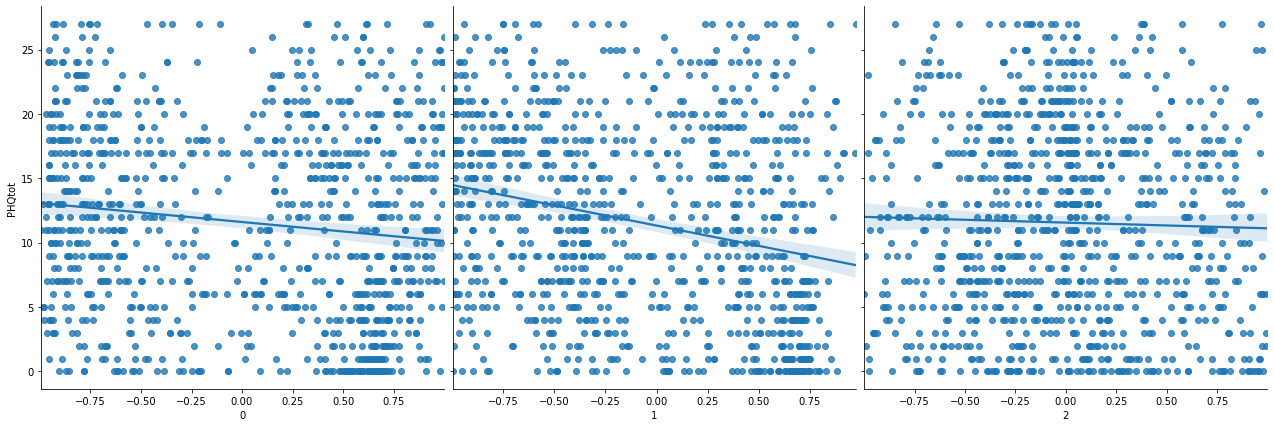

In [442]:
df_plot_dep, df_plot_wor = reduce_dim(3)
df_plot_dep.columns = ['0', '1', '2']
df_plot_wor.columns = ['0', '1', '2']

df_plot_dep['PHQtot'] = responses.PHQtot
df_plot_dep['minidep_diagnose'] = responses.minidep_diagnose

df_plot_wor['GADtot'] = responses.GADtot
df_plot_wor['miniGAD_diagnose'] = responses.miniGAD_diagnose

sns.pairplot(df_plot_dep, x_vars=['0', '1', '2'], y_vars='PHQtot', height=6, kind='reg')

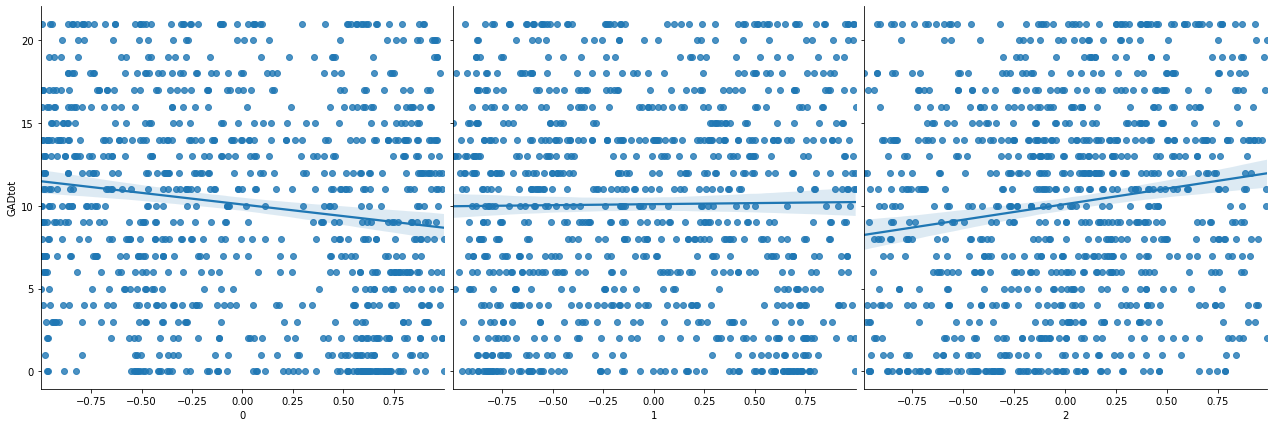

In [456]:
sns.pairplot(df_plot_wor, x_vars=['0', '1', '2'], y_vars='GADtot', height=6, kind='reg')

### Dimension Reduction using UMAP

/home/ma42/anaconda3/lib/python3.8/site-packages/umap/spectral.py:227: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  warn(


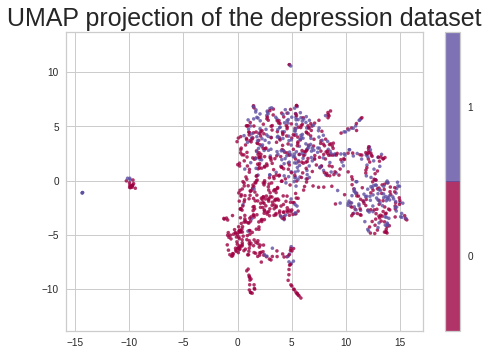

In [521]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer_dep = umap.UMAP(n_neighbors=3, min_dist=0.5)

#embedding = reducer.fit_transform(reduce_dim(56)[0]) #uses vectors with reduced dimensions (after PCA)
embedding_dep = reducer_dep.fit_transform(df_dep_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding_dep[:, 0], embedding_dep[:, 1], c=y_dep_diag, cmap='Spectral', s=10, alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the depression dataset', fontsize=25)
plt.show()

/home/ma42/anaconda3/lib/python3.8/site-packages/umap/spectral.py:227: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  warn(


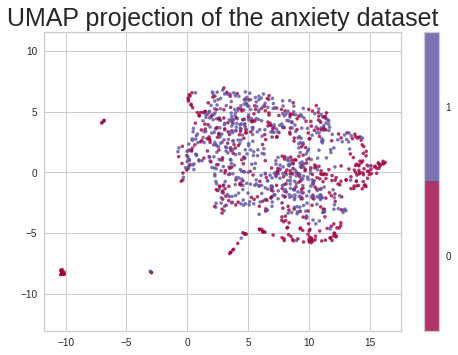

In [520]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer_wor = umap.UMAP(n_neighbors=3, min_dist=0.5)

#embedding = reducer.fit_transform(reduce_dim(74)[1]) #uses vectors with reduced dimensions (after PCA)
embedding_wor = reducer_wor.fit_transform(df_wor_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding_wor[:, 0], embedding_wor[:, 1], c=y_wor_diag, cmap='Spectral', s=10, alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the anxiety dataset', fontsize=25)
plt.show()

### Plotting feature 1 vs. feature 2 and coloring after diagnosis

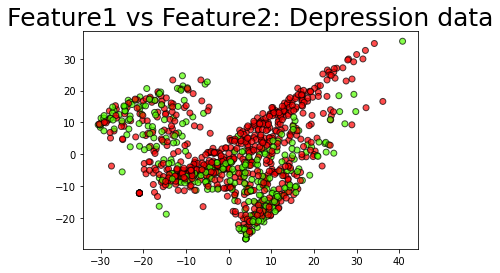

In [445]:
# Reduces concatinated response vectors into two dimensions and plots dim1 vs dim2. Colored after dep diagnosis.

X_pca_dep = reduce_dim(2, normalize=False)[0]

plt.scatter(X_pca_dep.values[:, 0], X_pca_dep.values[:, 1], c=y_dep_diag, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title('Feature1 vs Feature2: Depression data', fontsize=25)
plt.show()

#Vet inte riktigt vilken färger som representerar vad?  

**OBS**, using 2 dim only explains 14.9% (or PCA1: 8.8%, PCA2: 6.2%) of variance/information and hence should not be seen as a reliable representation/plot. In order to conserve 85% of the variance we need 220 dimensions.

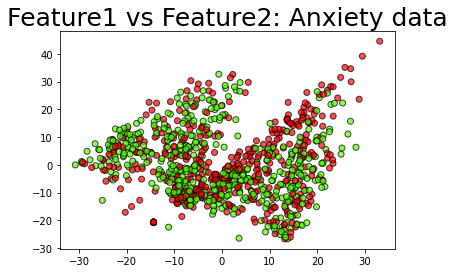

In [458]:
# Reduces concatinated response vectors into two dimensions and plots dim1 vs dim2. Colored after dep diagnosis.

X_pca_wor = reduce_dim(2, normalize=False)[1]

plt.scatter(X_pca_wor.values[:, 0], X_pca_wor.values[:, 1], c=y_wor_diag, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title('Feature1 vs Feature2: Anxiety data', fontsize=25)
plt.show()

#Vet inte riktigt vilken färger som representerar vad? 

**OBS**, using 2 dim only explains **14.4%** (or PCA1: 8.0%, PCA2: 6.3%) of variance/information and hence, should not be seen as a reliable representation/plot. In order to conserve 85% of the variance we need 222 dimensions.

### Plots of linear regression residuals

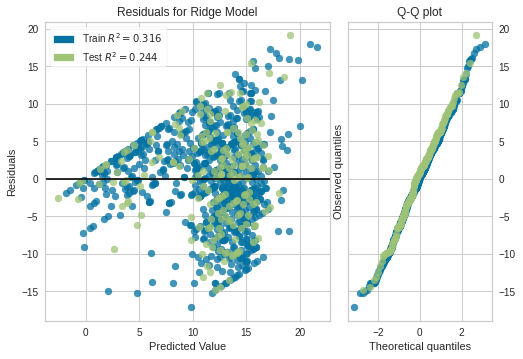

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [542]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

x_dep = df_dep_concat.values

scaler = StandardScaler()
pca_res = PCA(n_components=23)

X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

# Standardize and scale data
scaler.fit(X_train_dep) 
X_train_dep = scaler.transform(X_train_dep)
X_test_dep = scaler.transform(X_test_dep)

# Fit and reduce dimensions
pca_res.fit(X_train_dep)
X_train_dep = pca_res.transform(X_train_dep)
X_test_dep = pca_res.transform(X_test_dep)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train_dep, y_train_dep)
visualizer.score(X_test_dep, y_test_dep)
visualizer.show()

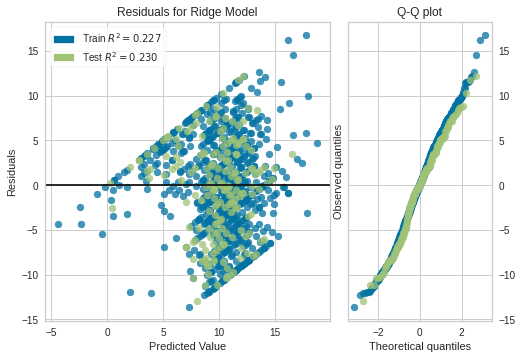

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [543]:
x_wor = df_wor_concat.values

scaler = StandardScaler()
pca_res = PCA(n_components=56)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

# Standardize and scale data
scaler.fit(X_train_wor) 
X_train_wor = scaler.transform(X_train_wor)
X_test_wor = scaler.transform(X_test_wor)

# Fit and reduce dimensions
pca_res.fit(X_train_wor)
X_train_wor = pca_res.transform(X_train_wor)
X_test_wor = pca_res.transform(X_test_wor)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train_wor, y_train_wor)
visualizer.score(X_test_wor, y_test_wor)
visualizer.show()

# Using the Semantic Representations in Analyses

### The dependent variable for worry and depression

In [589]:
"""
Semantic-numeric correlations. 
Analyzing the relationship between semantic responses and a numerical variable
"""
 
#The numerical rating scales for depression and worry
dep_scale = responses[['PHQtot']]
wor_scale = responses[['GADtot']]

#Checking for NaN values
dep_scale.isnull().values.any() #true
wor_scale.isnull().values.any() #true

def replace_nan(y_array):
    #Replaceing NaN values with mean value of column - perhaps we should do this differently
    col_mean = np.nanmean(y_array, axis=0)
    col_mean = np.around(col_mean, decimals=0, out=None) 
    inds = np.where(np.isnan(y_array))
    y_array[inds] = np.take(col_mean, inds[1])
    return y_array

#Create y - variables
y_wor_scale = wor_scale.values
y_dep_scale = dep_scale.values

#Replace NaN Values for the numerical scales
y_wor_scale = replace_nan(y_wor_scale).flatten()
y_dep_scale = replace_nan(y_dep_scale).flatten()

In [460]:
#The categorical variables, whether someone is diagnosed with worry/dep or not
dep_diag = responses[['minidep_diagnose']]
wor_diag = responses[['miniGAD_diagnose']]

print("Respondents with diagnose: {} out of {}".format(int(dep_diag.sum()), len(dep_diag))) #unbalanced
print("Respondents with diagnose: {} out of {}".format(int(wor_diag.sum()), len(wor_diag))) #not as unbalanced

#Checking for NaN values
dep_diag.isnull().values.any() #false
wor_diag.isnull().values.any() #false

#Create y - variables
y_wor_diag = wor_diag.values
y_dep_diag = dep_diag.values

Respondents with diagnose: 324 out of 976
Respondents with diagnose: 499 out of 976


Import packages needed for analysis

In [227]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder

## Analysis using a basic neural network

In [1526]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
pca = PCA(n_components=220)

Y = y_dep_scale
#Y = to_categorical(Y)
X = df_dep_concat.values 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=0)

scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [1527]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import regularizers

model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(32, activation='relu'))
model.add(Dense(28, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_939 (Dense)            (None, 256)               56576     
_________________________________________________________________
dense_940 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_941 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_942 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_943 (Dense)            (None, 28)                924       
Total params: 100,732
Trainable params: 100,732
Non-trainable params: 0
_________________________________________________________________


In [1528]:
history = model.fit(X_train, y_train, batch_size=100, epochs=100, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 1s 22ms/step - loss: 63.5790 - sparse_categorical_accuracy: 0.0323 - val_loss: 54.0779 - val_sparse_categorical_accuracy: 0.0561
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 52.0768 - sparse_categorical_accuracy: 0.0621 - val_loss: 46.2020 - val_sparse_categorical_accuracy: 0.0867
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 44.5349 - sparse_categorical_accuracy: 0.0950 - val_loss: 39.6345 - val_sparse_categorical_accuracy: 0.0918
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 38.1558 - sparse_categorical_accuracy: 0.1297 - val_loss: 33.8186 - val_sparse_categorical_accuracy: 0.1122
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 32.4589 - sparse_categorical_accuracy: 0.1449 - val_loss: 28.6083 - val_sparse_categorical_accuracy: 0.1173
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 27.4128 - sparse_categorical_accu

Epoch 47/100
8/8 [==============================] - 0s 6ms/step - loss: 3.5189 - sparse_categorical_accuracy: 0.1179 - val_loss: 3.6351 - val_sparse_categorical_accuracy: 0.1071
Epoch 48/100
8/8 [==============================] - 0s 6ms/step - loss: 3.5149 - sparse_categorical_accuracy: 0.1430 - val_loss: 3.6384 - val_sparse_categorical_accuracy: 0.1071
Epoch 49/100
8/8 [==============================] - 0s 6ms/step - loss: 3.4999 - sparse_categorical_accuracy: 0.1257 - val_loss: 3.6415 - val_sparse_categorical_accuracy: 0.1122
Epoch 50/100
8/8 [==============================] - 0s 6ms/step - loss: 3.4880 - sparse_categorical_accuracy: 0.1462 - val_loss: 3.6422 - val_sparse_categorical_accuracy: 0.1071
Epoch 51/100
8/8 [==============================] - 0s 6ms/step - loss: 3.5339 - sparse_categorical_accuracy: 0.1309 - val_loss: 3.6424 - val_sparse_categorical_accuracy: 0.1378
Epoch 52/100
8/8 [==============================] - 0s 6ms/step - loss: 3.5206 - sparse_categorical_accuracy: 

8/8 [==============================] - 0s 6ms/step - loss: 3.1937 - sparse_categorical_accuracy: 0.2354 - val_loss: 4.2305 - val_sparse_categorical_accuracy: 0.0969
Epoch 94/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1155 - sparse_categorical_accuracy: 0.2706 - val_loss: 4.2336 - val_sparse_categorical_accuracy: 0.1071
Epoch 95/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1549 - sparse_categorical_accuracy: 0.2226 - val_loss: 4.2525 - val_sparse_categorical_accuracy: 0.0918
Epoch 96/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1440 - sparse_categorical_accuracy: 0.2296 - val_loss: 4.2867 - val_sparse_categorical_accuracy: 0.1071
Epoch 97/100
8/8 [==============================] - 0s 5ms/step - loss: 3.1589 - sparse_categorical_accuracy: 0.2460 - val_loss: 4.3167 - val_sparse_categorical_accuracy: 0.1071
Epoch 98/100
8/8 [==============================] - 0s 6ms/step - loss: 3.1540 - sparse_categorical_accuracy: 0.2363 - val_

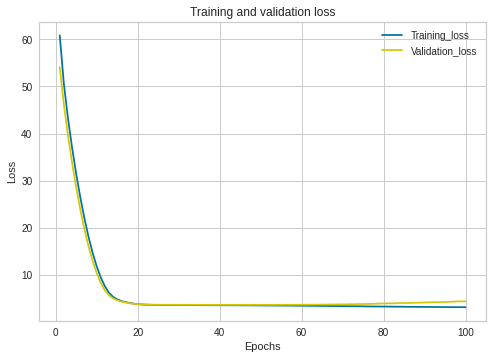

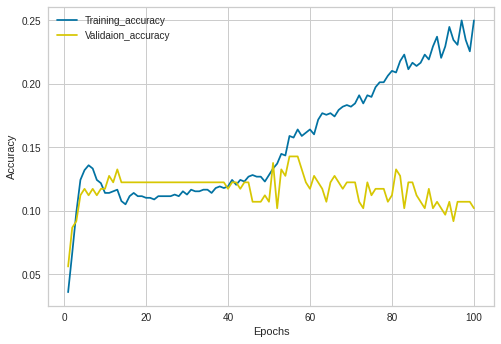

In [1529]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 101)
plt.plot(epochs, loss, 'b', label='Training_loss')
plt.plot(epochs, val_loss, 'y', label='Validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
plt.plot(epochs, acc, 'b', label='Training_accuracy')
plt.plot(epochs, val_acc, 'y', label='Validaion_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Analysis using logistic regression with matthews_corrcoef (MCC)

## Analysis using plain linear regression and numerical scales as dependent variable 

### Depression

**Mean Absolute Error (MAE):** $$MAE = \frac{1}{n}\sum^n_{i=1}|y_i-\hat{y_i}|$$
**Mean Squared Error (MSE):** $$MSE = \frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2$$
**Root Mean Squared Error (RMSE):** = $$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2}$$

MSE is more popular than MAE because MSE "punishes" larger errors. But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.

In [512]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

#x_dep = df_dep_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_dep =  reduce_dim(23)[0] #To use vectors with reduced dimensions (after PCA)

X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)
y_pred_dep = regr_dep.predict(X_test_dep) 

In [513]:
print("R2 training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 
#print("Intercept:  ", regr_dep.intercept_)

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
print("MAE: ", metrics.mean_absolute_error(y_pred_dep, y_test_dep))
print("MSE: ", metrics.mean_squared_error(y_pred_dep, y_test_dep))

R2 training data:   0.32154354077722813
R2 testing data:   0.2406588434918837

RMSE: 6.401252852600542
MAE:  5.167879462429341
MSE:  40.97603808292657


#### Linar regression scaling and pca on training set only:

In [496]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

x_dep = df_dep_concat.values #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2

scaler = StandardScaler()
pca_reg_dep = PCA(n_components=23)

#pca_reg_dep = PCA(n_components=56) #Instance of PCA that reduces nbr dim until 95% of variance is kept
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

scaler.fit(X_train_dep) #Fit on training set only. (Only fit on the training set!)
X_train_dep = scaler.transform(X_train_dep) # Apply transform to both the training set and the test set.
X_test_dep = scaler.transform(X_test_dep)

pca_reg_dep.fit(X_train_dep) #Fit PCA on training set. (Only fit on the training set!)
X_train_dep = pca_reg_dep.transform(X_train_dep)
X_test_dep = pca_reg_dep.transform(X_test_dep)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)
y_pred_dep = regr_dep.predict(X_test_dep) 

In [497]:
print("R2 training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 
#print("Intercept:  ", regr_dep.intercept_)

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
print("MAE: ", metrics.mean_absolute_error(y_pred_dep, y_test_dep))
print("MSE: ", metrics.mean_squared_error(y_pred_dep, y_test_dep))

R2 training data:   0.3164801067494206
R2 testing data:   0.24432698030333988

RMSE: 6.3857729219734365
MAE:  5.1745576351647635
MSE:  40.778095811009166


0.03571428571428578
0.14411649301126686


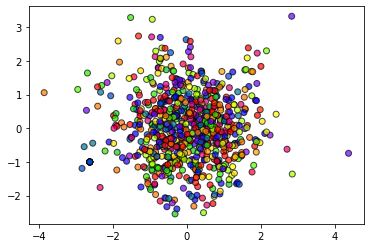

In [309]:
# Build and plot PCA to visualize the balance of the classes in the dataset

X_pca_dep = reduce_dim(2, X_dep=X_train_dep, normalize=False)[0]

plt.scatter(X_pca_dep.values[:, 0], X_pca_dep.values[:, 1], c=y_train_dep, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

#the PCA plot shows that the red class (diagnosed) is mostly represented 

#### Worry

In [471]:
"""Predicting the diagnosis on the basis of the representations by means 
of logistic regression """

#x_wor = df_wor_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_wor = reduce_dim(56)[1] #To use vectors with reduced dimensions (after PCA)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

regr_wor = LinearRegression()
regr_wor.fit(X_train_wor, y_train_wor)

y_pred_wor = regr_wor.predict(X_test_wor)

In [472]:
print("R2 score training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_wor, y_pred_wor)))
print("MAE: ", metrics.mean_absolute_error(y_pred_wor, y_test_wor))
print("MSE: ", metrics.mean_squared_error(y_pred_wor, y_test_wor))

R2 score training data:   0.224533804980799
R2 score testing data:   0.22023260166775838

RMSE: 5.309783414858409
MAE:  4.22463763795873
MSE:  28.193799912705433


#### Linar regression scaling and pca on training set only:

In [473]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

x_wor = df_wor_concat.values #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2

scaler_wor = StandardScaler()
pca_reg_wor = PCA(n_components=56)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

scaler_wor.fit(X_train_wor) #Fit on training set only. (Only fit on the training set!)
X_train_wor = scaler_wor.transform(X_train_wor) # Apply transform to both the training set and the test set.
X_test_wor = scaler_wor.transform(X_test_wor)

pca_reg_wor.fit(X_train_wor) #Fit PCA on training set. (Only fit on the training set!)
X_train_wor = pca_reg_wor.transform(X_train_wor)
X_test_wor = pca_reg_wor.transform(X_test_wor)

regr_wor = LinearRegression().fit(X_train_wor, y_train_wor)
y_pred_wor = regr_wor.predict(X_test_wor)

In [474]:
print("R2 score training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_wor, y_pred_wor)))
print("MAE: ", metrics.mean_absolute_error(y_pred_wor, y_test_wor))
print("MSE: ", metrics.mean_squared_error(y_pred_wor, y_test_wor))

R2 score training data:   0.23093713875324162
R2 score testing data:   0.22607360175196656

RMSE: 5.289859047711136
MAE:  4.289531401857974
MSE:  27.982608744651372


# Examining optimal number of dimensions

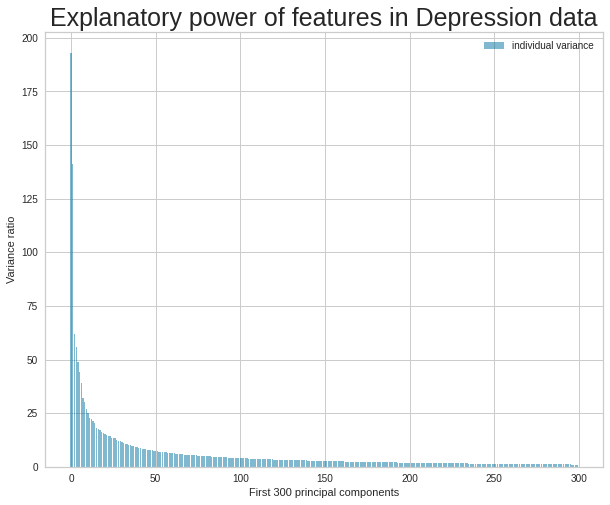

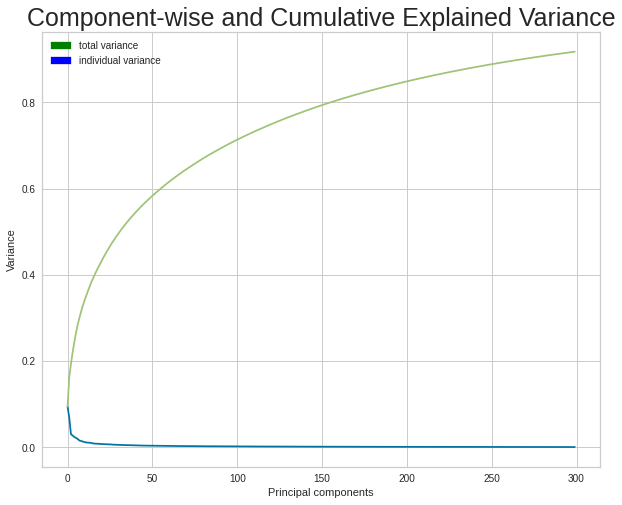

In [581]:
x_dep = df_dep_concat.values
scaler = StandardScaler()
x_dep = scaler.fit_transform(x_dep) 

# Visualize
pca = PCA()
pca.fit_transform(x_dep)
pca_variance = pca.explained_variance_

plt.figure(figsize=(10, 8))
plt.bar(range(300), pca_variance[:300], alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.title('Explanatory power of features in Depression data', fontsize=25)
plt.ylabel('Variance ratio')
plt.xlabel('First 300 principal components')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(300), pca.explained_variance_ratio_[:300])
plt.plot(range(300), np.cumsum(pca.explained_variance_ratio_[:300]))
plt.ylabel('Variance')
plt.xlabel('Principal components')
green_patch = mpatches.Patch(color='green', label='total variance')
blue_patch = mpatches.Patch(color='blue', label='individual variance')
plt.legend(handles=[green_patch, blue_patch])
plt.title("Component-wise and Cumulative Explained Variance", fontsize=25)
plt.show()

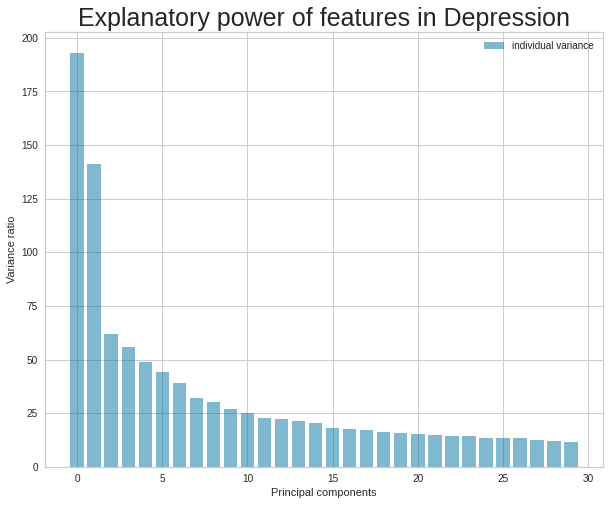

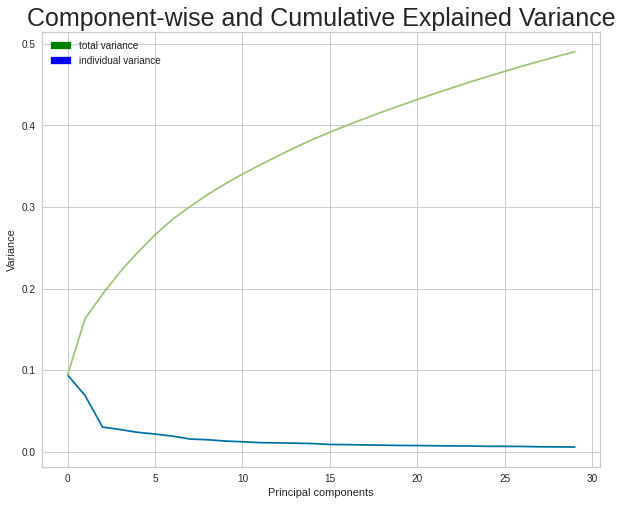

In [582]:
x_dep = df_dep_concat.values
scaler = StandardScaler()
x_dep = scaler.fit_transform(x_dep) 

# Visualize
pca = PCA(n_components=30)
pca.fit_transform(x_dep)
pca_variance = pca.explained_variance_

plt.figure(figsize=(10, 8))
plt.bar(range(30), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.title('Explanatory power of features in Depression', fontsize=25)
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(30), pca.explained_variance_ratio_)
plt.plot(range(30), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Variance')
plt.xlabel('Principal components')
green_patch = mpatches.Patch(color='green', label='total variance')
blue_patch = mpatches.Patch(color='blue', label='individual variance')
plt.legend(handles=[green_patch, blue_patch])
plt.title("Component-wise and Cumulative Explained Variance", fontsize=25)
plt.show()

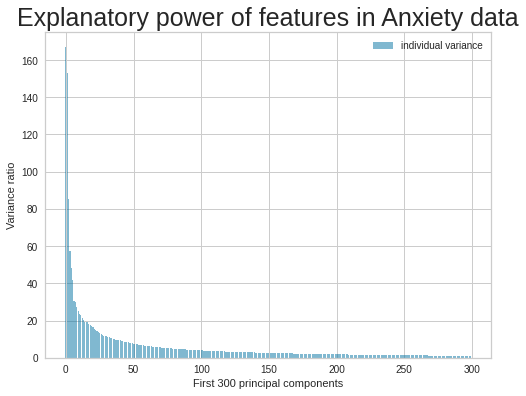

In [555]:
x_wor = df_wor_concat.values
scaler = StandardScaler()
x_wor = scaler.fit_transform(x_wor) 

# Visualize
pca = PCA()
pca.fit_transform(x_wor)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(300), pca_variance[:300], alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.title('Explanatory power of features in Anxiety data', fontsize=25)
plt.ylabel('Variance ratio')
plt.xlabel('First 300 principal components')
plt.show()

### Using the method described in the article combined with plain linear regression

In [ ]:
"""In practice, this was simply achieved by adding 1, 
then multiplying by 1.3 and finally rounding to the nearest integer 
(e.g., 1, 3, 5, 8, where the next number of dimen- sions to be tested are the first 12; 
in other words ([8 􏰃 1] 􏰍 1.3).
In previous research, we have found this sequence to be valid and computationally efficient"""


In [226]:
#initializing values
n, min_err = 1, np.inf
new_x = df_wor_concat

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)


while n < len(df_wor_concat.columns):
    
    #split data into train and test data
    X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(new_x, y_wor_scale, test_size=0.2, random_state=0)
    y_train_wor = y_train_wor.flatten() 
    y_test_wor = y_test_wor.flatten()
    
    regr_wor = LinearRegression()
    
    #fit data
    regr_wor.fit(X_train_wor, y_train_wor)
    
    #make prediction 
    y_pred_wor = regr_wor.predict(X_test_wor) 
    
    #test prediction with mean squared error 
    err = mean_absolute_error(y_test_wor, y_pred_wor)
    
    #compare err with current min err to then later choose the nbr of dimensions that give minimum mean squared error
    if err < min_err:
        min_err = err
        dimensions = n
        r2 = regr_wor.score(X_test_wor, y_test_wor)
        
    n=round((n+1)*1.3)
    new_x=df_wor_concat.iloc[:,:n] 

print('Nbr of dimensions to use : ', dimensions) #According to this we should use 98 dimensions in the next steps?
print(min_err)
print(r2)

Nbr of dimensions to use :  42
4.645276592893303
0.10949551677885505


In [225]:
"Using the depression data to test how many dimensions to keep"

y_dim = y_dep_scale
dimension, min_error = 0, np.inf
i = 1

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dim = df_dep_concat.iloc[:,:i]
    X_train_dim, X_test_dim, y_train_dim, y_test_dim = train_test_split(x_dim, y_dim, test_size=0.2, random_state=0)

    regr_dim = LinearRegression()
    
    regr_dim.fit(X_train_dim, y_train_dim)
    y_pred_dim = regr_dim.predict(X_test_dim) 
    
    mae = mean_absolute_error(y_test_dim, y_pred_dim)
    
    if mae < min_error: 
        min_error = mae
        dimension = i
        r2 = regr_dim.score(X_test_dim, y_test_dim)
    #print(i, mse)
    i = round((i + 1)*1.3)
    
print('\nNbr of dimensions to use: ', dimension)
print(min_error, r2)


Nbr of dimensions to use:  31
5.560679584352172 0.15271508382464205


## Cross validation techniques

## Examining optimal number of dimensions using method described in article combined with leave 10% cross validation

### Depression

In [465]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#reduce_dim(k)[0] => To use dep vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dep_cv = df_dep_concat.iloc[:,:i]
    
    scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension))

Best score: 5.777955925887754 with dimension: 23


#### Gradually increase dimensions in PCA and keep best performing number of dims

In [489]:
#Leave 10% out cross validation while testing the number of dimensions after PCA that will give the best over all score. 

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, np.inf
i = 1

while i < 976:
    x_dep_cv = reduce_dim(i)[0]

    scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if abs(scores.mean()) < min_error:
        min_error = abs(scores.mean())
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension))

Best score: 4.925962857743481 with dimension: 98


### Anxiety

In [466]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_wor_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#reduce_dim(k)[1] => To use wor vectors with reduced dimensions (after PCA)

while i < len(df_wor_concat.columns):
    x_wor_cv = df_wor_concat.iloc[:,:i]
    
    scores = cross_val_score(reg, x_wor_cv, y_wor_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension)) 

Best score: 5.02349119906215 with dimension: 56




# Results examining optimal number of dimensions

#### Depression

Technique | Original dimension | R2 score | MSE | MAE | Nbr dimensions
----- | --- | --- | --- | --- | --- |
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.040 | 51.80 | |17
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048	 | 0.136 | 46.62 | |56
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.025 | 6.828 | 5.64 | 74 / 56 (with MAE)
same as over, w/ nltk cleaning | Full concat: 2048 |  |  | 5.77 | 23


#### Anxiety

Technique | Original dimension | R2 score | MSE | MAE | Nbr dimensions
----- | --- | --- | --- | --- | --- |
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.131 | 31.42 | |56
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048 | 0.131 | 31.42 | |98
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.112 | 7.169 | 5.06 | 56 / 31 (with MAE)
same as over, w/ nltk cleaning | Full concat: 2048 |  |  | 5.023 | 56

#### Test: Leave 10% out cross validation on PCA reduced vectors

In [223]:
#Leave 10% out cross validation using PCA reduced vectors

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
x_dep_cv = reduce_dim(56)[0] #=> To use vectors with reduced dimensions (after PCA)

#Options for scoring: 'r2', 'neg_root_mean_squared_error' 
scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print(abs(scores))

[3.81998821 5.31817986 6.1456299  5.56090648 2.61572575 7.31041483
 4.93716096 6.34555402 5.05431914 4.39063793 5.81540648 7.8205074
 3.8088826  6.45909285 5.80949722 2.60167221 6.02715333 5.26292695
 5.76326024 5.43704595 5.30724772 3.27663993 6.13503276 5.11000175
 4.88958078 4.62466787 4.44830899 5.58577002 8.32971556 6.66397147
 5.83467441 8.55054152 6.81315206 4.08817357 4.14164455 6.46684394
 4.29874129 5.61223758 4.65300879 5.09627037 4.19608548 3.47273981
 5.87672528 3.60476062 6.49425415 6.43824768 6.15164872 4.40045609
 6.24631786 4.38468901 4.11899772 4.24776034 3.11403677 2.4879327
 5.15109757 6.85568213 3.45617557 2.8731914  5.76691924 4.71534097
 7.99264514 7.23783272 5.5315805  9.21928018 5.82022266 3.00955493
 4.25078084 5.27070798 6.22466088 4.4639865  5.90648679 5.04523944
 6.70202916 3.52133367 5.70025198 3.70408071 4.30578296 4.99522197
 4.52499415 4.30652364 4.37374297 5.84132969 5.38655906 4.47012636
 4.9200826  5.86907856 5.25028095 3.22275596 3.61612773 4.151394